# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [59]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

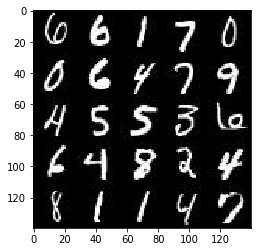

In [60]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

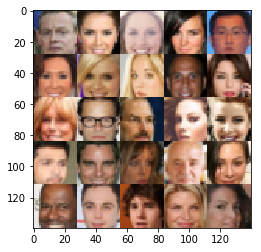

In [61]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [62]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [63]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real_images = tf.placeholder(tf.float32, shape=(None,image_width, image_height, image_channels))
    z_input = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())
    return input_real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [64]:
def discriminator(images, reuse=False, alpha = 0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding = 'same')
        leaky_relu = tf.maximum(alpha*x, x)
        x = tf.layers.conv2d(leaky_relu, 128, 5, strides=2, padding = 'same')
        x = tf.layers.batch_normalization(x, training=True)
        leaky_relu = tf.maximum(alpha*x, x)
        x = tf.layers.conv2d(leaky_relu, 256, 5 , strides=2, padding = 'same')
        x = tf.layers.batch_normalization(x, training=True)
        leaky_relu = tf.maximum(alpha*x, x)
        
        
        x = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(x, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [65]:
def generator(z, out_channel_dim, is_train=True, alpha= 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    prob = 0.9
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 7*7*512)
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        leaky_relu = tf.maximum(alpha * x, x)
        x = tf.layers.conv2d_transpose(leaky_relu, 256, 5, strides=2, padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        leaky_relu = tf.maximum(alpha * x, x)
        x = tf.nn.dropout(leaky_relu, keep_prob=prob)
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=is_train)
        leaky_relu = tf.maximum(alpha * x, x)   
        x = tf.nn.dropout(leaky_relu, keep_prob=prob)
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 3, strides=1, padding='same', activation=None)
        output = tf.tanh(logits)
        return output



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [66]:
def model_loss(input_real, input_z, out_channel_dim, alpha = 0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [67]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    update_opt = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    with tf.control_dependencies(update_opt):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [68]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [71]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)

    
    saver = tf.train.Saver()
    losses = []
    steps = 0
    total_steps = epoch_count * batch_size

    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


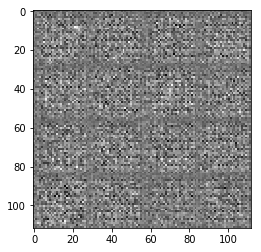

Epoch 1/2... Generator Loss: 2.4499 Discriminator Loss: 0.1829...
Epoch 1/2... Generator Loss: 3.6665 Discriminator Loss: 0.0959...
Epoch 1/2... Generator Loss: 4.2639 Discriminator Loss: 0.0342...
Epoch 1/2... Generator Loss: 3.9682 Discriminator Loss: 0.0346...
Epoch 1/2... Generator Loss: 3.5743 Discriminator Loss: 0.0434...
Epoch 1/2... Generator Loss: 5.2483 Discriminator Loss: 0.0185...
Epoch 1/2... Generator Loss: 5.4920 Discriminator Loss: 0.0124...
Epoch 1/2... Generator Loss: 4.6737 Discriminator Loss: 0.0165...
Epoch 1/2... Generator Loss: 5.1458 Discriminator Loss: 0.0100...
Epoch 1/2... Generator Loss: 5.1954 Discriminator Loss: 0.0094...


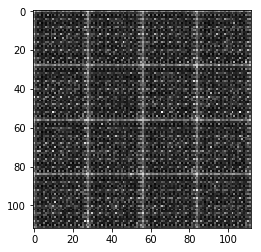

Epoch 1/2... Generator Loss: 5.3407 Discriminator Loss: 0.0091...
Epoch 1/2... Generator Loss: 10.7165 Discriminator Loss: 0.0265...
Epoch 1/2... Generator Loss: 5.4188 Discriminator Loss: 0.0148...
Epoch 1/2... Generator Loss: 4.4630 Discriminator Loss: 0.0296...
Epoch 1/2... Generator Loss: 4.1713 Discriminator Loss: 0.0345...
Epoch 1/2... Generator Loss: 24.9540 Discriminator Loss: 0.0819...
Epoch 1/2... Generator Loss: 7.7986 Discriminator Loss: 0.0011...
Epoch 1/2... Generator Loss: 10.7754 Discriminator Loss: 0.0628...
Epoch 1/2... Generator Loss: 8.4953 Discriminator Loss: 0.0004...
Epoch 1/2... Generator Loss: 6.3151 Discriminator Loss: 0.0034...


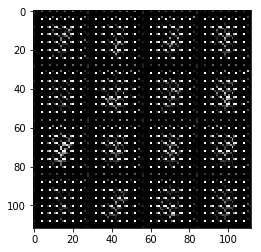

Epoch 1/2... Generator Loss: 6.1478 Discriminator Loss: 0.0034...
Epoch 1/2... Generator Loss: 5.8772 Discriminator Loss: 0.0036...
Epoch 1/2... Generator Loss: 5.9401 Discriminator Loss: 0.0068...
Epoch 1/2... Generator Loss: 5.8681 Discriminator Loss: 0.0051...
Epoch 1/2... Generator Loss: 6.2495 Discriminator Loss: 0.0029...
Epoch 1/2... Generator Loss: 6.2300 Discriminator Loss: 0.0031...
Epoch 1/2... Generator Loss: 5.6353 Discriminator Loss: 0.0050...
Epoch 1/2... Generator Loss: 19.5277 Discriminator Loss: 4.2159...
Epoch 1/2... Generator Loss: 13.2819 Discriminator Loss: 1.9243...
Epoch 1/2... Generator Loss: 0.8663 Discriminator Loss: 1.1566...


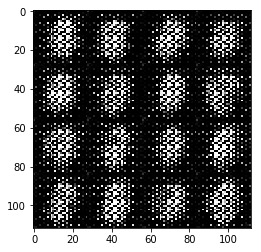

Epoch 1/2... Generator Loss: 1.8975 Discriminator Loss: 0.4724...
Epoch 1/2... Generator Loss: 1.2658 Discriminator Loss: 1.8902...
Epoch 1/2... Generator Loss: 2.4708 Discriminator Loss: 0.6292...
Epoch 1/2... Generator Loss: 1.9986 Discriminator Loss: 0.7215...
Epoch 1/2... Generator Loss: 1.5109 Discriminator Loss: 0.7611...
Epoch 1/2... Generator Loss: 0.8049 Discriminator Loss: 1.1212...
Epoch 1/2... Generator Loss: 0.5725 Discriminator Loss: 1.3386...
Epoch 1/2... Generator Loss: 0.4997 Discriminator Loss: 1.4682...
Epoch 1/2... Generator Loss: 1.3063 Discriminator Loss: 0.9294...
Epoch 1/2... Generator Loss: 0.9357 Discriminator Loss: 0.9184...


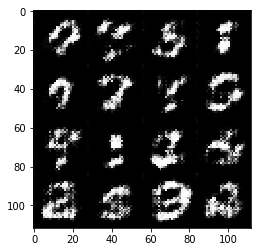

Epoch 1/2... Generator Loss: 1.1406 Discriminator Loss: 1.1806...
Epoch 1/2... Generator Loss: 1.0263 Discriminator Loss: 1.0646...
Epoch 1/2... Generator Loss: 0.4813 Discriminator Loss: 1.3349...
Epoch 1/2... Generator Loss: 0.7430 Discriminator Loss: 1.1657...
Epoch 1/2... Generator Loss: 0.6502 Discriminator Loss: 1.1401...
Epoch 1/2... Generator Loss: 1.8347 Discriminator Loss: 0.8115...
Epoch 1/2... Generator Loss: 1.2736 Discriminator Loss: 0.9407...
Epoch 1/2... Generator Loss: 0.7488 Discriminator Loss: 1.0735...
Epoch 1/2... Generator Loss: 0.9747 Discriminator Loss: 0.7980...
Epoch 1/2... Generator Loss: 1.0354 Discriminator Loss: 0.9142...


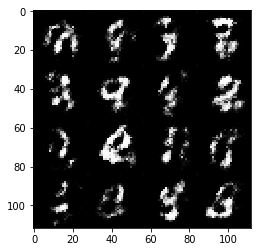

Epoch 1/2... Generator Loss: 0.8242 Discriminator Loss: 0.8445...
Epoch 1/2... Generator Loss: 0.5968 Discriminator Loss: 1.2050...
Epoch 1/2... Generator Loss: 1.3201 Discriminator Loss: 0.7548...
Epoch 1/2... Generator Loss: 1.2653 Discriminator Loss: 0.6208...
Epoch 1/2... Generator Loss: 1.0414 Discriminator Loss: 0.7950...
Epoch 1/2... Generator Loss: 1.8253 Discriminator Loss: 0.7676...
Epoch 1/2... Generator Loss: 1.3083 Discriminator Loss: 0.7369...
Epoch 1/2... Generator Loss: 0.9893 Discriminator Loss: 0.9843...
Epoch 1/2... Generator Loss: 1.0565 Discriminator Loss: 0.8340...
Epoch 1/2... Generator Loss: 1.4450 Discriminator Loss: 0.6582...


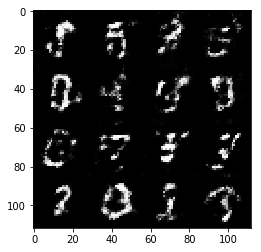

Epoch 1/2... Generator Loss: 1.1230 Discriminator Loss: 0.7822...
Epoch 1/2... Generator Loss: 1.2836 Discriminator Loss: 0.6999...
Epoch 1/2... Generator Loss: 0.6096 Discriminator Loss: 1.0309...
Epoch 1/2... Generator Loss: 1.5649 Discriminator Loss: 0.7787...
Epoch 1/2... Generator Loss: 0.5821 Discriminator Loss: 1.0923...
Epoch 1/2... Generator Loss: 2.5758 Discriminator Loss: 0.9147...
Epoch 1/2... Generator Loss: 1.6724 Discriminator Loss: 0.6132...
Epoch 1/2... Generator Loss: 1.0214 Discriminator Loss: 0.7115...
Epoch 1/2... Generator Loss: 0.7562 Discriminator Loss: 0.9051...
Epoch 1/2... Generator Loss: 0.7888 Discriminator Loss: 0.8011...


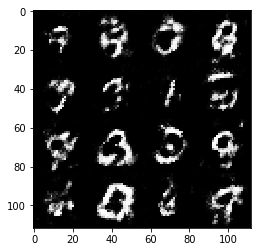

Epoch 1/2... Generator Loss: 1.0822 Discriminator Loss: 0.6096...
Epoch 1/2... Generator Loss: 1.7161 Discriminator Loss: 0.4940...
Epoch 1/2... Generator Loss: 1.6217 Discriminator Loss: 0.5608...
Epoch 1/2... Generator Loss: 2.3694 Discriminator Loss: 0.6144...
Epoch 1/2... Generator Loss: 3.6307 Discriminator Loss: 1.4675...
Epoch 1/2... Generator Loss: 1.2000 Discriminator Loss: 0.6298...
Epoch 1/2... Generator Loss: 2.9837 Discriminator Loss: 1.1262...
Epoch 1/2... Generator Loss: 1.6098 Discriminator Loss: 0.5948...
Epoch 1/2... Generator Loss: 1.4464 Discriminator Loss: 0.5425...
Epoch 1/2... Generator Loss: 0.9523 Discriminator Loss: 0.7182...


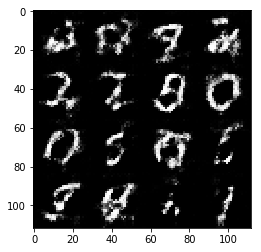

Epoch 1/2... Generator Loss: 1.3839 Discriminator Loss: 0.6046...
Epoch 1/2... Generator Loss: 0.8404 Discriminator Loss: 0.7937...
Epoch 1/2... Generator Loss: 1.9920 Discriminator Loss: 0.6159...
Epoch 1/2... Generator Loss: 0.7777 Discriminator Loss: 0.9985...
Epoch 1/2... Generator Loss: 2.0509 Discriminator Loss: 0.6160...
Epoch 1/2... Generator Loss: 1.6656 Discriminator Loss: 0.9227...
Epoch 1/2... Generator Loss: 1.2192 Discriminator Loss: 0.7230...
Epoch 1/2... Generator Loss: 1.1093 Discriminator Loss: 0.6889...
Epoch 1/2... Generator Loss: 0.5137 Discriminator Loss: 1.3429...
Epoch 1/2... Generator Loss: 0.9850 Discriminator Loss: 0.8499...


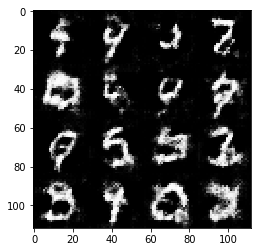

Epoch 1/2... Generator Loss: 1.0463 Discriminator Loss: 0.7788...
Epoch 1/2... Generator Loss: 0.5044 Discriminator Loss: 1.1529...
Epoch 1/2... Generator Loss: 0.5873 Discriminator Loss: 1.1614...
Epoch 2/2... Generator Loss: 0.7704 Discriminator Loss: 0.8892...
Epoch 2/2... Generator Loss: 0.9415 Discriminator Loss: 0.8598...
Epoch 2/2... Generator Loss: 1.1075 Discriminator Loss: 0.9031...
Epoch 2/2... Generator Loss: 0.3232 Discriminator Loss: 1.6145...
Epoch 2/2... Generator Loss: 2.3302 Discriminator Loss: 1.1214...
Epoch 2/2... Generator Loss: 1.3070 Discriminator Loss: 0.9589...
Epoch 2/2... Generator Loss: 0.8492 Discriminator Loss: 0.9118...


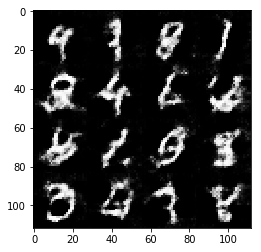

Epoch 2/2... Generator Loss: 2.3362 Discriminator Loss: 1.1056...
Epoch 2/2... Generator Loss: 0.8102 Discriminator Loss: 0.9098...
Epoch 2/2... Generator Loss: 1.1697 Discriminator Loss: 0.7842...
Epoch 2/2... Generator Loss: 1.5704 Discriminator Loss: 0.8884...
Epoch 2/2... Generator Loss: 1.2304 Discriminator Loss: 0.9258...
Epoch 2/2... Generator Loss: 1.0377 Discriminator Loss: 0.7761...
Epoch 2/2... Generator Loss: 0.7797 Discriminator Loss: 0.9639...
Epoch 2/2... Generator Loss: 0.8855 Discriminator Loss: 0.8757...
Epoch 2/2... Generator Loss: 2.4917 Discriminator Loss: 1.3033...
Epoch 2/2... Generator Loss: 1.2983 Discriminator Loss: 0.6975...


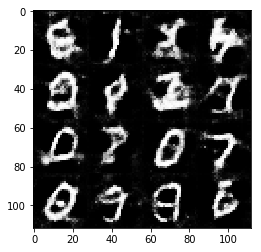

Epoch 2/2... Generator Loss: 1.1859 Discriminator Loss: 0.8609...
Epoch 2/2... Generator Loss: 1.3123 Discriminator Loss: 0.7058...
Epoch 2/2... Generator Loss: 1.9820 Discriminator Loss: 1.0289...
Epoch 2/2... Generator Loss: 1.6523 Discriminator Loss: 0.7914...
Epoch 2/2... Generator Loss: 0.8485 Discriminator Loss: 0.8333...
Epoch 2/2... Generator Loss: 1.5239 Discriminator Loss: 0.6976...
Epoch 2/2... Generator Loss: 0.7905 Discriminator Loss: 0.9950...
Epoch 2/2... Generator Loss: 1.7236 Discriminator Loss: 0.6952...
Epoch 2/2... Generator Loss: 1.1412 Discriminator Loss: 0.8351...
Epoch 2/2... Generator Loss: 1.3727 Discriminator Loss: 0.8596...


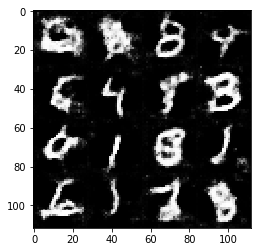

Epoch 2/2... Generator Loss: 1.1155 Discriminator Loss: 0.7168...
Epoch 2/2... Generator Loss: 1.1813 Discriminator Loss: 0.8284...
Epoch 2/2... Generator Loss: 0.9412 Discriminator Loss: 0.7672...
Epoch 2/2... Generator Loss: 0.5449 Discriminator Loss: 1.1890...
Epoch 2/2... Generator Loss: 0.7977 Discriminator Loss: 0.8935...
Epoch 2/2... Generator Loss: 0.5477 Discriminator Loss: 1.1285...
Epoch 2/2... Generator Loss: 2.2724 Discriminator Loss: 1.1383...
Epoch 2/2... Generator Loss: 0.9868 Discriminator Loss: 0.8452...
Epoch 2/2... Generator Loss: 1.0932 Discriminator Loss: 0.8529...
Epoch 2/2... Generator Loss: 0.6318 Discriminator Loss: 1.0817...


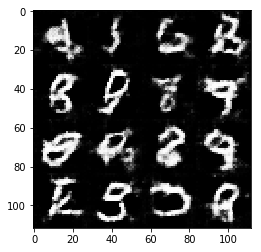

Epoch 2/2... Generator Loss: 0.2726 Discriminator Loss: 1.6468...
Epoch 2/2... Generator Loss: 0.9881 Discriminator Loss: 0.8314...
Epoch 2/2... Generator Loss: 1.1812 Discriminator Loss: 0.8711...
Epoch 2/2... Generator Loss: 1.4982 Discriminator Loss: 1.1197...
Epoch 2/2... Generator Loss: 0.5576 Discriminator Loss: 1.0817...
Epoch 2/2... Generator Loss: 1.4225 Discriminator Loss: 0.7881...
Epoch 2/2... Generator Loss: 1.1079 Discriminator Loss: 0.7238...
Epoch 2/2... Generator Loss: 0.8682 Discriminator Loss: 0.8755...
Epoch 2/2... Generator Loss: 1.8258 Discriminator Loss: 0.6421...
Epoch 2/2... Generator Loss: 2.0376 Discriminator Loss: 1.0560...


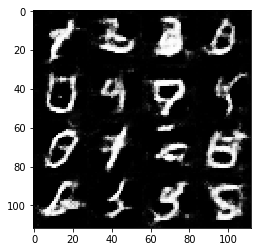

Epoch 2/2... Generator Loss: 1.2788 Discriminator Loss: 0.7500...
Epoch 2/2... Generator Loss: 1.5711 Discriminator Loss: 0.6667...
Epoch 2/2... Generator Loss: 1.7000 Discriminator Loss: 0.7438...
Epoch 2/2... Generator Loss: 0.8199 Discriminator Loss: 0.8351...
Epoch 2/2... Generator Loss: 1.0104 Discriminator Loss: 0.8549...
Epoch 2/2... Generator Loss: 1.0300 Discriminator Loss: 0.7182...
Epoch 2/2... Generator Loss: 0.9210 Discriminator Loss: 0.8234...
Epoch 2/2... Generator Loss: 1.7291 Discriminator Loss: 0.8902...
Epoch 2/2... Generator Loss: 1.3280 Discriminator Loss: 0.6801...
Epoch 2/2... Generator Loss: 0.4316 Discriminator Loss: 1.3252...


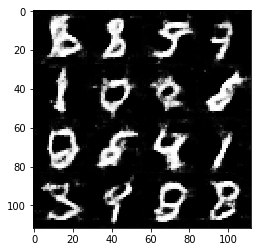

Epoch 2/2... Generator Loss: 0.5090 Discriminator Loss: 1.1837...
Epoch 2/2... Generator Loss: 1.4900 Discriminator Loss: 0.8808...
Epoch 2/2... Generator Loss: 1.3368 Discriminator Loss: 0.8239...
Epoch 2/2... Generator Loss: 1.1638 Discriminator Loss: 0.8259...
Epoch 2/2... Generator Loss: 1.2669 Discriminator Loss: 0.8256...
Epoch 2/2... Generator Loss: 0.8308 Discriminator Loss: 0.8838...
Epoch 2/2... Generator Loss: 0.7344 Discriminator Loss: 0.9311...
Epoch 2/2... Generator Loss: 1.1266 Discriminator Loss: 0.7870...
Epoch 2/2... Generator Loss: 0.9599 Discriminator Loss: 0.7676...
Epoch 2/2... Generator Loss: 1.4802 Discriminator Loss: 0.7625...


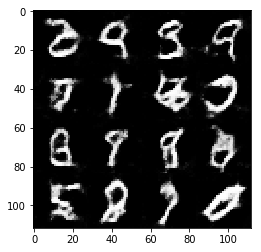

Epoch 2/2... Generator Loss: 0.4739 Discriminator Loss: 1.2155...
Epoch 2/2... Generator Loss: 0.7187 Discriminator Loss: 0.9237...
Epoch 2/2... Generator Loss: 0.8885 Discriminator Loss: 0.7483...
Epoch 2/2... Generator Loss: 0.5311 Discriminator Loss: 1.0953...
Epoch 2/2... Generator Loss: 0.5060 Discriminator Loss: 1.0989...
Epoch 2/2... Generator Loss: 0.7016 Discriminator Loss: 0.9607...
Epoch 2/2... Generator Loss: 1.5033 Discriminator Loss: 0.8643...
Epoch 2/2... Generator Loss: 1.5540 Discriminator Loss: 0.7166...
Epoch 2/2... Generator Loss: 1.5154 Discriminator Loss: 0.7186...
Epoch 2/2... Generator Loss: 0.9728 Discriminator Loss: 0.8898...


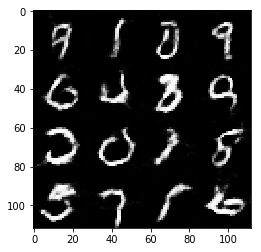

Epoch 2/2... Generator Loss: 0.9948 Discriminator Loss: 0.8930...
Epoch 2/2... Generator Loss: 0.6122 Discriminator Loss: 1.0105...
Epoch 2/2... Generator Loss: 1.1676 Discriminator Loss: 0.7668...
Epoch 2/2... Generator Loss: 1.0185 Discriminator Loss: 0.6881...
Epoch 2/2... Generator Loss: 0.9862 Discriminator Loss: 0.6923...
Epoch 2/2... Generator Loss: 0.4503 Discriminator Loss: 1.2406...
Epoch 2/2... Generator Loss: 0.9929 Discriminator Loss: 0.7123...
Epoch 2/2... Generator Loss: 0.7327 Discriminator Loss: 0.8260...
Epoch 2/2... Generator Loss: 1.7173 Discriminator Loss: 0.7011...
Epoch 2/2... Generator Loss: 0.9888 Discriminator Loss: 0.7999...


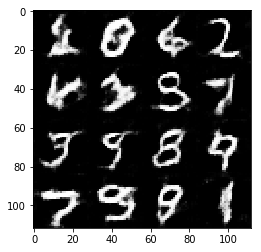

Epoch 2/2... Generator Loss: 1.3508 Discriminator Loss: 0.6461...
Epoch 2/2... Generator Loss: 1.4335 Discriminator Loss: 0.5970...
Epoch 2/2... Generator Loss: 1.3215 Discriminator Loss: 0.7306...
Epoch 2/2... Generator Loss: 0.8501 Discriminator Loss: 0.7699...
Epoch 2/2... Generator Loss: 1.8216 Discriminator Loss: 0.8386...
Epoch 2/2... Generator Loss: 0.7681 Discriminator Loss: 0.8797...
Epoch 2/2... Generator Loss: 0.4687 Discriminator Loss: 1.1776...


In [72]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


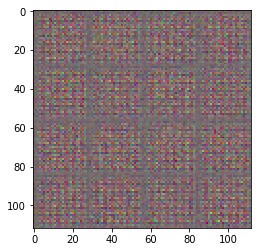

Epoch 1/1... Generator Loss: 3.3964 Discriminator Loss: 0.1575...
Epoch 1/1... Generator Loss: 4.3917 Discriminator Loss: 0.1002...
Epoch 1/1... Generator Loss: 3.4579 Discriminator Loss: 0.1050...
Epoch 1/1... Generator Loss: 1.8448 Discriminator Loss: 0.4111...
Epoch 1/1... Generator Loss: 18.1273 Discriminator Loss: 0.4520...
Epoch 1/1... Generator Loss: 3.4772 Discriminator Loss: 0.1670...
Epoch 1/1... Generator Loss: 0.3513 Discriminator Loss: 2.7479...
Epoch 1/1... Generator Loss: 3.4031 Discriminator Loss: 0.7753...
Epoch 1/1... Generator Loss: 2.2833 Discriminator Loss: 0.5341...
Epoch 1/1... Generator Loss: 1.4722 Discriminator Loss: 0.7149...


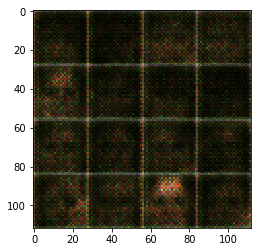

Epoch 1/1... Generator Loss: 1.4461 Discriminator Loss: 0.5503...
Epoch 1/1... Generator Loss: 1.8289 Discriminator Loss: 0.3126...
Epoch 1/1... Generator Loss: 6.9509 Discriminator Loss: 0.7171...
Epoch 1/1... Generator Loss: 2.8802 Discriminator Loss: 0.1374...
Epoch 1/1... Generator Loss: 6.9800 Discriminator Loss: 0.9309...
Epoch 1/1... Generator Loss: 2.2451 Discriminator Loss: 0.2315...
Epoch 1/1... Generator Loss: 2.3345 Discriminator Loss: 0.2011...
Epoch 1/1... Generator Loss: 3.4087 Discriminator Loss: 0.2261...
Epoch 1/1... Generator Loss: 2.0148 Discriminator Loss: 0.3063...
Epoch 1/1... Generator Loss: 1.5873 Discriminator Loss: 0.4004...


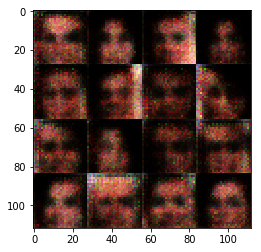

Epoch 1/1... Generator Loss: 5.3742 Discriminator Loss: 0.3296...
Epoch 1/1... Generator Loss: 1.1932 Discriminator Loss: 0.5657...
Epoch 1/1... Generator Loss: 1.6272 Discriminator Loss: 0.3941...
Epoch 1/1... Generator Loss: 2.3643 Discriminator Loss: 0.2645...
Epoch 1/1... Generator Loss: 4.2965 Discriminator Loss: 1.4045...
Epoch 1/1... Generator Loss: 0.6309 Discriminator Loss: 1.0172...
Epoch 1/1... Generator Loss: 2.6766 Discriminator Loss: 0.2999...
Epoch 1/1... Generator Loss: 0.2888 Discriminator Loss: 1.6369...
Epoch 1/1... Generator Loss: 2.8353 Discriminator Loss: 0.5496...
Epoch 1/1... Generator Loss: 1.4432 Discriminator Loss: 1.2604...


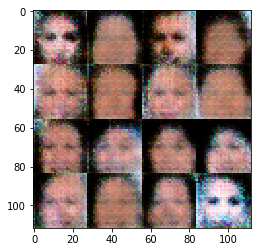

Epoch 1/1... Generator Loss: 0.8521 Discriminator Loss: 0.8523...
Epoch 1/1... Generator Loss: 0.1753 Discriminator Loss: 2.1729...
Epoch 1/1... Generator Loss: 2.4856 Discriminator Loss: 1.0581...
Epoch 1/1... Generator Loss: 0.3918 Discriminator Loss: 1.5703...
Epoch 1/1... Generator Loss: 0.0999 Discriminator Loss: 2.7166...
Epoch 1/1... Generator Loss: 1.3023 Discriminator Loss: 0.6563...
Epoch 1/1... Generator Loss: 0.3186 Discriminator Loss: 1.6720...
Epoch 1/1... Generator Loss: 1.4001 Discriminator Loss: 0.7707...
Epoch 1/1... Generator Loss: 2.8854 Discriminator Loss: 0.8942...
Epoch 1/1... Generator Loss: 0.4285 Discriminator Loss: 1.3737...


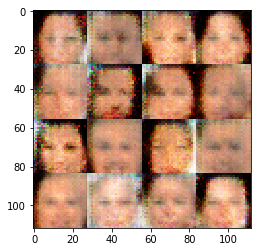

Epoch 1/1... Generator Loss: 0.7918 Discriminator Loss: 0.8358...
Epoch 1/1... Generator Loss: 4.0236 Discriminator Loss: 1.3364...
Epoch 1/1... Generator Loss: 4.1769 Discriminator Loss: 1.9319...
Epoch 1/1... Generator Loss: 0.1951 Discriminator Loss: 2.2558...
Epoch 1/1... Generator Loss: 2.7488 Discriminator Loss: 0.5506...
Epoch 1/1... Generator Loss: 2.5692 Discriminator Loss: 0.7719...
Epoch 1/1... Generator Loss: 1.5902 Discriminator Loss: 0.7375...
Epoch 1/1... Generator Loss: 2.6960 Discriminator Loss: 0.7414...
Epoch 1/1... Generator Loss: 0.4199 Discriminator Loss: 1.3089...
Epoch 1/1... Generator Loss: 2.7491 Discriminator Loss: 1.3032...


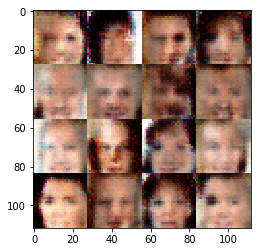

Epoch 1/1... Generator Loss: 1.4156 Discriminator Loss: 0.8681...
Epoch 1/1... Generator Loss: 0.9053 Discriminator Loss: 1.0848...
Epoch 1/1... Generator Loss: 0.7626 Discriminator Loss: 1.1949...
Epoch 1/1... Generator Loss: 2.8358 Discriminator Loss: 1.3342...
Epoch 1/1... Generator Loss: 2.9819 Discriminator Loss: 0.8373...
Epoch 1/1... Generator Loss: 2.5968 Discriminator Loss: 1.0080...
Epoch 1/1... Generator Loss: 0.8826 Discriminator Loss: 0.7644...
Epoch 1/1... Generator Loss: 0.8267 Discriminator Loss: 0.9209...
Epoch 1/1... Generator Loss: 0.6650 Discriminator Loss: 1.0268...
Epoch 1/1... Generator Loss: 0.6286 Discriminator Loss: 1.2306...


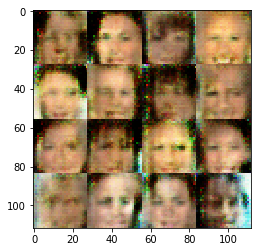

Epoch 1/1... Generator Loss: 0.7834 Discriminator Loss: 1.2107...
Epoch 1/1... Generator Loss: 0.8007 Discriminator Loss: 0.9668...
Epoch 1/1... Generator Loss: 1.9625 Discriminator Loss: 0.8325...
Epoch 1/1... Generator Loss: 1.5467 Discriminator Loss: 0.6384...
Epoch 1/1... Generator Loss: 0.8709 Discriminator Loss: 0.8937...
Epoch 1/1... Generator Loss: 3.7851 Discriminator Loss: 1.8703...
Epoch 1/1... Generator Loss: 3.2300 Discriminator Loss: 1.7737...
Epoch 1/1... Generator Loss: 2.1759 Discriminator Loss: 1.1016...
Epoch 1/1... Generator Loss: 0.5254 Discriminator Loss: 1.3880...
Epoch 1/1... Generator Loss: 2.0515 Discriminator Loss: 0.9112...


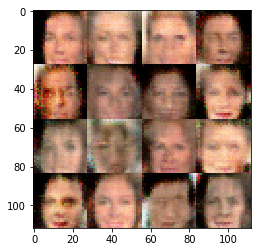

Epoch 1/1... Generator Loss: 1.3210 Discriminator Loss: 0.6367...
Epoch 1/1... Generator Loss: 1.5583 Discriminator Loss: 0.5958...
Epoch 1/1... Generator Loss: 1.3966 Discriminator Loss: 0.9881...
Epoch 1/1... Generator Loss: 1.6988 Discriminator Loss: 0.6758...
Epoch 1/1... Generator Loss: 0.6894 Discriminator Loss: 1.0777...
Epoch 1/1... Generator Loss: 2.6912 Discriminator Loss: 1.3230...
Epoch 1/1... Generator Loss: 0.8132 Discriminator Loss: 1.0130...
Epoch 1/1... Generator Loss: 0.3992 Discriminator Loss: 1.3782...
Epoch 1/1... Generator Loss: 0.3824 Discriminator Loss: 1.4426...
Epoch 1/1... Generator Loss: 0.2855 Discriminator Loss: 1.7153...


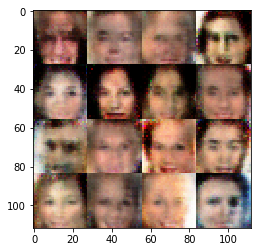

Epoch 1/1... Generator Loss: 1.1363 Discriminator Loss: 0.8755...
Epoch 1/1... Generator Loss: 1.5188 Discriminator Loss: 1.0299...
Epoch 1/1... Generator Loss: 0.4455 Discriminator Loss: 1.3105...
Epoch 1/1... Generator Loss: 1.4218 Discriminator Loss: 1.0445...
Epoch 1/1... Generator Loss: 1.0141 Discriminator Loss: 0.9842...
Epoch 1/1... Generator Loss: 0.7593 Discriminator Loss: 1.1588...
Epoch 1/1... Generator Loss: 0.2827 Discriminator Loss: 1.6546...
Epoch 1/1... Generator Loss: 1.2060 Discriminator Loss: 0.8425...
Epoch 1/1... Generator Loss: 2.4288 Discriminator Loss: 1.1254...
Epoch 1/1... Generator Loss: 0.2523 Discriminator Loss: 1.7079...


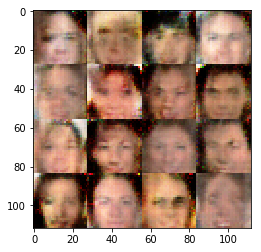

Epoch 1/1... Generator Loss: 1.2614 Discriminator Loss: 1.0417...
Epoch 1/1... Generator Loss: 0.5073 Discriminator Loss: 1.1418...
Epoch 1/1... Generator Loss: 0.5336 Discriminator Loss: 1.0964...
Epoch 1/1... Generator Loss: 2.1512 Discriminator Loss: 1.1604...
Epoch 1/1... Generator Loss: 1.6243 Discriminator Loss: 0.8571...
Epoch 1/1... Generator Loss: 0.9511 Discriminator Loss: 1.0487...
Epoch 1/1... Generator Loss: 0.5613 Discriminator Loss: 1.1736...
Epoch 1/1... Generator Loss: 0.7144 Discriminator Loss: 1.0935...
Epoch 1/1... Generator Loss: 0.7323 Discriminator Loss: 1.0260...
Epoch 1/1... Generator Loss: 0.4055 Discriminator Loss: 1.2745...


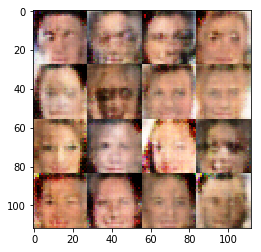

Epoch 1/1... Generator Loss: 0.8360 Discriminator Loss: 1.0086...
Epoch 1/1... Generator Loss: 1.1577 Discriminator Loss: 0.7136...
Epoch 1/1... Generator Loss: 1.2855 Discriminator Loss: 0.7630...
Epoch 1/1... Generator Loss: 1.0493 Discriminator Loss: 0.9756...
Epoch 1/1... Generator Loss: 0.8147 Discriminator Loss: 0.8483...
Epoch 1/1... Generator Loss: 1.2360 Discriminator Loss: 1.2007...
Epoch 1/1... Generator Loss: 0.4966 Discriminator Loss: 1.3442...
Epoch 1/1... Generator Loss: 0.7880 Discriminator Loss: 0.9455...
Epoch 1/1... Generator Loss: 0.6463 Discriminator Loss: 1.0781...
Epoch 1/1... Generator Loss: 0.5069 Discriminator Loss: 1.1706...


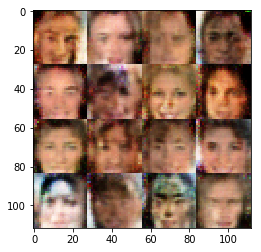

Epoch 1/1... Generator Loss: 2.2700 Discriminator Loss: 1.3054...
Epoch 1/1... Generator Loss: 1.7086 Discriminator Loss: 0.7928...
Epoch 1/1... Generator Loss: 0.7673 Discriminator Loss: 0.9636...
Epoch 1/1... Generator Loss: 1.1085 Discriminator Loss: 1.1331...
Epoch 1/1... Generator Loss: 0.2803 Discriminator Loss: 1.6117...
Epoch 1/1... Generator Loss: 0.8800 Discriminator Loss: 1.0309...
Epoch 1/1... Generator Loss: 0.8952 Discriminator Loss: 0.9388...
Epoch 1/1... Generator Loss: 0.9742 Discriminator Loss: 0.9787...
Epoch 1/1... Generator Loss: 0.7490 Discriminator Loss: 1.0180...
Epoch 1/1... Generator Loss: 0.5099 Discriminator Loss: 1.2536...


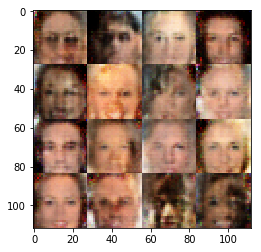

Epoch 1/1... Generator Loss: 0.8448 Discriminator Loss: 0.9722...
Epoch 1/1... Generator Loss: 1.2321 Discriminator Loss: 1.0413...
Epoch 1/1... Generator Loss: 0.5482 Discriminator Loss: 1.2590...
Epoch 1/1... Generator Loss: 1.4009 Discriminator Loss: 1.3890...
Epoch 1/1... Generator Loss: 0.3188 Discriminator Loss: 1.5971...
Epoch 1/1... Generator Loss: 0.6464 Discriminator Loss: 1.0637...
Epoch 1/1... Generator Loss: 0.7459 Discriminator Loss: 1.0031...
Epoch 1/1... Generator Loss: 0.9712 Discriminator Loss: 0.9084...
Epoch 1/1... Generator Loss: 0.7904 Discriminator Loss: 1.0410...
Epoch 1/1... Generator Loss: 1.7165 Discriminator Loss: 1.0115...


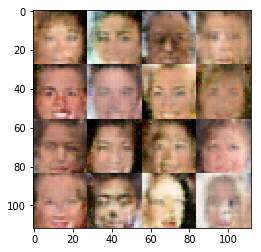

Epoch 1/1... Generator Loss: 0.4031 Discriminator Loss: 1.3860...
Epoch 1/1... Generator Loss: 1.3835 Discriminator Loss: 0.8406...
Epoch 1/1... Generator Loss: 0.6332 Discriminator Loss: 1.2661...
Epoch 1/1... Generator Loss: 1.2245 Discriminator Loss: 1.2446...
Epoch 1/1... Generator Loss: 1.0398 Discriminator Loss: 1.0192...
Epoch 1/1... Generator Loss: 0.7120 Discriminator Loss: 1.2027...
Epoch 1/1... Generator Loss: 0.2615 Discriminator Loss: 1.7459...
Epoch 1/1... Generator Loss: 0.7840 Discriminator Loss: 1.0437...
Epoch 1/1... Generator Loss: 0.6156 Discriminator Loss: 1.0866...
Epoch 1/1... Generator Loss: 0.9067 Discriminator Loss: 1.0675...


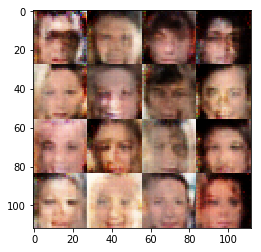

Epoch 1/1... Generator Loss: 1.1226 Discriminator Loss: 1.0631...
Epoch 1/1... Generator Loss: 0.6628 Discriminator Loss: 1.2345...
Epoch 1/1... Generator Loss: 0.7164 Discriminator Loss: 1.1261...
Epoch 1/1... Generator Loss: 0.7209 Discriminator Loss: 1.1581...
Epoch 1/1... Generator Loss: 0.7509 Discriminator Loss: 0.9925...
Epoch 1/1... Generator Loss: 1.1971 Discriminator Loss: 1.0696...
Epoch 1/1... Generator Loss: 0.2504 Discriminator Loss: 1.8332...
Epoch 1/1... Generator Loss: 1.1266 Discriminator Loss: 1.2292...
Epoch 1/1... Generator Loss: 0.9580 Discriminator Loss: 1.3345...
Epoch 1/1... Generator Loss: 0.7591 Discriminator Loss: 1.0623...


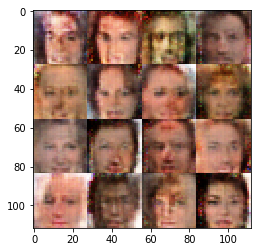

Epoch 1/1... Generator Loss: 1.1294 Discriminator Loss: 0.8171...
Epoch 1/1... Generator Loss: 0.7436 Discriminator Loss: 1.2519...
Epoch 1/1... Generator Loss: 0.4647 Discriminator Loss: 1.2479...
Epoch 1/1... Generator Loss: 1.0648 Discriminator Loss: 1.1511...
Epoch 1/1... Generator Loss: 1.2123 Discriminator Loss: 1.5155...
Epoch 1/1... Generator Loss: 0.6413 Discriminator Loss: 1.2003...
Epoch 1/1... Generator Loss: 1.0474 Discriminator Loss: 1.1862...
Epoch 1/1... Generator Loss: 0.5389 Discriminator Loss: 1.2016...
Epoch 1/1... Generator Loss: 0.4428 Discriminator Loss: 1.1815...
Epoch 1/1... Generator Loss: 0.6159 Discriminator Loss: 1.2890...


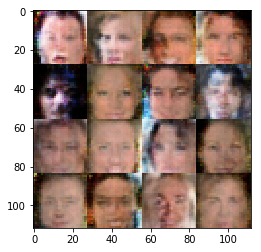

Epoch 1/1... Generator Loss: 0.4430 Discriminator Loss: 1.3962...
Epoch 1/1... Generator Loss: 1.1735 Discriminator Loss: 0.9455...
Epoch 1/1... Generator Loss: 1.0640 Discriminator Loss: 1.2097...
Epoch 1/1... Generator Loss: 0.5575 Discriminator Loss: 1.3958...
Epoch 1/1... Generator Loss: 0.4397 Discriminator Loss: 1.2100...
Epoch 1/1... Generator Loss: 0.6350 Discriminator Loss: 1.0398...
Epoch 1/1... Generator Loss: 0.8577 Discriminator Loss: 1.2034...
Epoch 1/1... Generator Loss: 0.9433 Discriminator Loss: 1.0210...
Epoch 1/1... Generator Loss: 0.4841 Discriminator Loss: 1.1608...
Epoch 1/1... Generator Loss: 0.5994 Discriminator Loss: 1.2541...


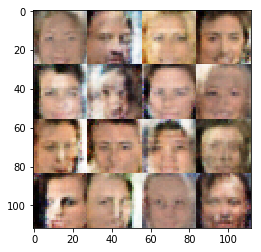

Epoch 1/1... Generator Loss: 0.5909 Discriminator Loss: 1.3556...
Epoch 1/1... Generator Loss: 0.5280 Discriminator Loss: 1.1595...
Epoch 1/1... Generator Loss: 0.8253 Discriminator Loss: 1.1446...
Epoch 1/1... Generator Loss: 0.4418 Discriminator Loss: 1.3972...
Epoch 1/1... Generator Loss: 0.5702 Discriminator Loss: 1.3362...
Epoch 1/1... Generator Loss: 0.7791 Discriminator Loss: 1.2782...
Epoch 1/1... Generator Loss: 0.6298 Discriminator Loss: 1.1509...
Epoch 1/1... Generator Loss: 0.3068 Discriminator Loss: 1.6189...
Epoch 1/1... Generator Loss: 0.6527 Discriminator Loss: 1.3643...
Epoch 1/1... Generator Loss: 0.9542 Discriminator Loss: 1.0811...


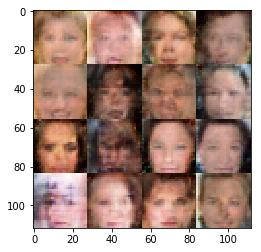

Epoch 1/1... Generator Loss: 0.8865 Discriminator Loss: 0.9212...
Epoch 1/1... Generator Loss: 1.2177 Discriminator Loss: 0.9955...
Epoch 1/1... Generator Loss: 0.5811 Discriminator Loss: 1.6659...
Epoch 1/1... Generator Loss: 0.9289 Discriminator Loss: 1.1535...
Epoch 1/1... Generator Loss: 0.4657 Discriminator Loss: 1.5324...
Epoch 1/1... Generator Loss: 0.5994 Discriminator Loss: 1.3464...
Epoch 1/1... Generator Loss: 0.8891 Discriminator Loss: 1.1383...
Epoch 1/1... Generator Loss: 0.5693 Discriminator Loss: 1.4622...
Epoch 1/1... Generator Loss: 0.7384 Discriminator Loss: 1.0577...
Epoch 1/1... Generator Loss: 0.3519 Discriminator Loss: 1.5456...


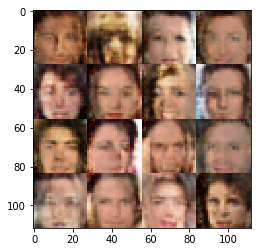

Epoch 1/1... Generator Loss: 0.6101 Discriminator Loss: 1.2861...
Epoch 1/1... Generator Loss: 0.8701 Discriminator Loss: 1.2776...
Epoch 1/1... Generator Loss: 0.6648 Discriminator Loss: 1.4113...
Epoch 1/1... Generator Loss: 0.6184 Discriminator Loss: 1.2348...
Epoch 1/1... Generator Loss: 0.7180 Discriminator Loss: 1.2033...
Epoch 1/1... Generator Loss: 0.5659 Discriminator Loss: 1.1761...
Epoch 1/1... Generator Loss: 0.7054 Discriminator Loss: 1.0518...
Epoch 1/1... Generator Loss: 1.0545 Discriminator Loss: 1.2773...
Epoch 1/1... Generator Loss: 0.6704 Discriminator Loss: 1.2985...
Epoch 1/1... Generator Loss: 0.4960 Discriminator Loss: 1.3319...


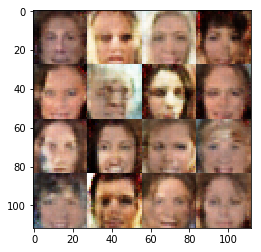

Epoch 1/1... Generator Loss: 0.8538 Discriminator Loss: 0.9858...
Epoch 1/1... Generator Loss: 0.3436 Discriminator Loss: 1.5837...
Epoch 1/1... Generator Loss: 0.2772 Discriminator Loss: 1.6781...
Epoch 1/1... Generator Loss: 0.4043 Discriminator Loss: 1.4611...
Epoch 1/1... Generator Loss: 0.4153 Discriminator Loss: 1.3498...
Epoch 1/1... Generator Loss: 1.0656 Discriminator Loss: 0.9064...
Epoch 1/1... Generator Loss: 0.5896 Discriminator Loss: 1.3986...
Epoch 1/1... Generator Loss: 0.6056 Discriminator Loss: 1.2296...
Epoch 1/1... Generator Loss: 0.6654 Discriminator Loss: 1.1602...
Epoch 1/1... Generator Loss: 0.5973 Discriminator Loss: 1.2470...


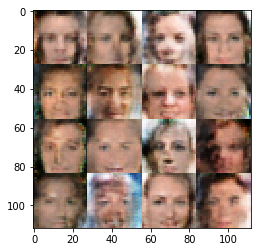

Epoch 1/1... Generator Loss: 0.6313 Discriminator Loss: 1.1768...
Epoch 1/1... Generator Loss: 0.5107 Discriminator Loss: 1.2594...
Epoch 1/1... Generator Loss: 0.8476 Discriminator Loss: 0.9872...
Epoch 1/1... Generator Loss: 0.4171 Discriminator Loss: 1.4816...
Epoch 1/1... Generator Loss: 0.4627 Discriminator Loss: 1.3260...
Epoch 1/1... Generator Loss: 0.6864 Discriminator Loss: 1.5241...
Epoch 1/1... Generator Loss: 1.0965 Discriminator Loss: 1.2674...
Epoch 1/1... Generator Loss: 0.6991 Discriminator Loss: 1.2521...
Epoch 1/1... Generator Loss: 0.5279 Discriminator Loss: 1.4133...
Epoch 1/1... Generator Loss: 0.7325 Discriminator Loss: 1.2704...


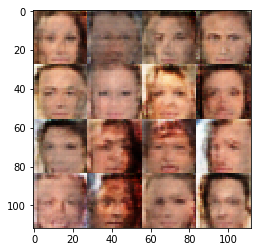

Epoch 1/1... Generator Loss: 0.6659 Discriminator Loss: 1.1298...
Epoch 1/1... Generator Loss: 0.5155 Discriminator Loss: 1.3241...
Epoch 1/1... Generator Loss: 0.3426 Discriminator Loss: 1.6873...
Epoch 1/1... Generator Loss: 0.9601 Discriminator Loss: 1.1399...
Epoch 1/1... Generator Loss: 0.7377 Discriminator Loss: 1.1701...
Epoch 1/1... Generator Loss: 0.6203 Discriminator Loss: 1.1566...
Epoch 1/1... Generator Loss: 0.4878 Discriminator Loss: 1.3815...
Epoch 1/1... Generator Loss: 0.9553 Discriminator Loss: 1.2115...
Epoch 1/1... Generator Loss: 0.4672 Discriminator Loss: 1.3734...
Epoch 1/1... Generator Loss: 0.5044 Discriminator Loss: 1.5765...


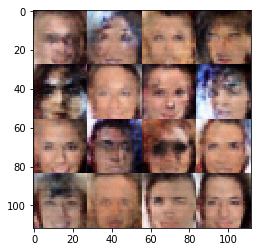

Epoch 1/1... Generator Loss: 0.6186 Discriminator Loss: 1.4056...
Epoch 1/1... Generator Loss: 0.8768 Discriminator Loss: 0.9855...
Epoch 1/1... Generator Loss: 0.8169 Discriminator Loss: 1.1050...
Epoch 1/1... Generator Loss: 0.3759 Discriminator Loss: 1.5374...
Epoch 1/1... Generator Loss: 0.4495 Discriminator Loss: 1.4575...
Epoch 1/1... Generator Loss: 0.7195 Discriminator Loss: 1.1314...
Epoch 1/1... Generator Loss: 0.9834 Discriminator Loss: 1.0393...
Epoch 1/1... Generator Loss: 0.6766 Discriminator Loss: 1.6314...
Epoch 1/1... Generator Loss: 0.4987 Discriminator Loss: 1.3269...
Epoch 1/1... Generator Loss: 0.7001 Discriminator Loss: 1.2495...


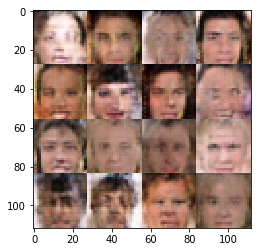

Epoch 1/1... Generator Loss: 0.3518 Discriminator Loss: 1.5623...
Epoch 1/1... Generator Loss: 0.5833 Discriminator Loss: 1.4257...
Epoch 1/1... Generator Loss: 0.7245 Discriminator Loss: 1.0665...
Epoch 1/1... Generator Loss: 0.9934 Discriminator Loss: 1.1146...
Epoch 1/1... Generator Loss: 0.6563 Discriminator Loss: 1.2178...
Epoch 1/1... Generator Loss: 0.6919 Discriminator Loss: 1.4721...
Epoch 1/1... Generator Loss: 0.6580 Discriminator Loss: 1.0809...
Epoch 1/1... Generator Loss: 0.9895 Discriminator Loss: 0.9611...
Epoch 1/1... Generator Loss: 0.7514 Discriminator Loss: 1.3103...
Epoch 1/1... Generator Loss: 0.7345 Discriminator Loss: 1.1137...


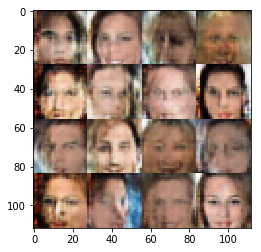

Epoch 1/1... Generator Loss: 0.8072 Discriminator Loss: 1.0679...
Epoch 1/1... Generator Loss: 0.5398 Discriminator Loss: 1.3296...
Epoch 1/1... Generator Loss: 0.4411 Discriminator Loss: 1.5758...
Epoch 1/1... Generator Loss: 0.4521 Discriminator Loss: 1.4434...
Epoch 1/1... Generator Loss: 0.7266 Discriminator Loss: 1.1647...
Epoch 1/1... Generator Loss: 1.0253 Discriminator Loss: 0.8714...
Epoch 1/1... Generator Loss: 0.4191 Discriminator Loss: 1.3940...
Epoch 1/1... Generator Loss: 0.5162 Discriminator Loss: 1.2061...
Epoch 1/1... Generator Loss: 0.3104 Discriminator Loss: 1.6173...
Epoch 1/1... Generator Loss: 0.3516 Discriminator Loss: 1.5337...


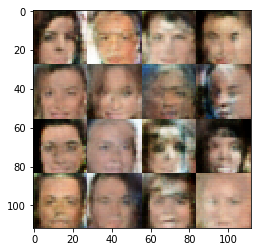

Epoch 1/1... Generator Loss: 0.3398 Discriminator Loss: 1.6183...
Epoch 1/1... Generator Loss: 0.7141 Discriminator Loss: 1.2593...
Epoch 1/1... Generator Loss: 0.7630 Discriminator Loss: 1.3165...
Epoch 1/1... Generator Loss: 0.8951 Discriminator Loss: 1.1244...
Epoch 1/1... Generator Loss: 0.2376 Discriminator Loss: 2.5779...
Epoch 1/1... Generator Loss: 0.7648 Discriminator Loss: 1.4461...
Epoch 1/1... Generator Loss: 0.6407 Discriminator Loss: 1.4704...
Epoch 1/1... Generator Loss: 0.8650 Discriminator Loss: 1.2118...
Epoch 1/1... Generator Loss: 0.6133 Discriminator Loss: 1.1051...
Epoch 1/1... Generator Loss: 0.3527 Discriminator Loss: 1.5250...


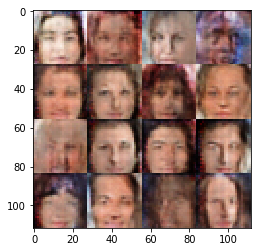

Epoch 1/1... Generator Loss: 0.4984 Discriminator Loss: 1.3463...
Epoch 1/1... Generator Loss: 0.7914 Discriminator Loss: 1.1560...
Epoch 1/1... Generator Loss: 0.8465 Discriminator Loss: 1.2783...
Epoch 1/1... Generator Loss: 0.5937 Discriminator Loss: 1.3707...
Epoch 1/1... Generator Loss: 0.8322 Discriminator Loss: 1.1801...
Epoch 1/1... Generator Loss: 0.4001 Discriminator Loss: 1.5469...
Epoch 1/1... Generator Loss: 0.6372 Discriminator Loss: 1.2254...
Epoch 1/1... Generator Loss: 0.7624 Discriminator Loss: 1.3643...
Epoch 1/1... Generator Loss: 0.5752 Discriminator Loss: 1.3807...
Epoch 1/1... Generator Loss: 0.5637 Discriminator Loss: 1.2240...


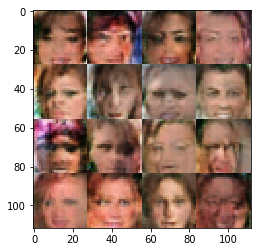

Epoch 1/1... Generator Loss: 0.4885 Discriminator Loss: 1.3621...
Epoch 1/1... Generator Loss: 0.9613 Discriminator Loss: 1.0954...
Epoch 1/1... Generator Loss: 0.5679 Discriminator Loss: 1.2587...
Epoch 1/1... Generator Loss: 0.4461 Discriminator Loss: 1.4468...
Epoch 1/1... Generator Loss: 0.4064 Discriminator Loss: 1.3874...
Epoch 1/1... Generator Loss: 0.8349 Discriminator Loss: 1.1033...
Epoch 1/1... Generator Loss: 0.5178 Discriminator Loss: 1.5482...
Epoch 1/1... Generator Loss: 0.9130 Discriminator Loss: 1.4520...
Epoch 1/1... Generator Loss: 0.7032 Discriminator Loss: 1.3895...
Epoch 1/1... Generator Loss: 0.8938 Discriminator Loss: 1.0270...


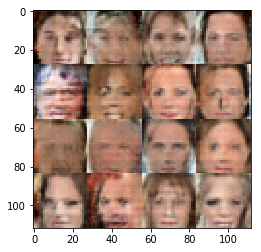

Epoch 1/1... Generator Loss: 0.6816 Discriminator Loss: 1.2535...
Epoch 1/1... Generator Loss: 0.6414 Discriminator Loss: 1.1601...
Epoch 1/1... Generator Loss: 0.5143 Discriminator Loss: 1.3774...
Epoch 1/1... Generator Loss: 0.8294 Discriminator Loss: 1.2098...
Epoch 1/1... Generator Loss: 0.5042 Discriminator Loss: 1.5727...
Epoch 1/1... Generator Loss: 0.6895 Discriminator Loss: 1.2586...
Epoch 1/1... Generator Loss: 0.9200 Discriminator Loss: 1.1045...
Epoch 1/1... Generator Loss: 0.5171 Discriminator Loss: 1.3767...
Epoch 1/1... Generator Loss: 0.4847 Discriminator Loss: 1.3501...
Epoch 1/1... Generator Loss: 0.6490 Discriminator Loss: 1.1302...


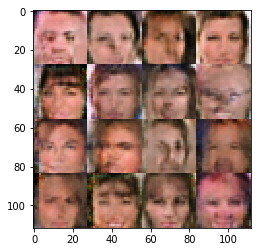

Epoch 1/1... Generator Loss: 0.6168 Discriminator Loss: 1.3858...
Epoch 1/1... Generator Loss: 0.9725 Discriminator Loss: 0.9836...
Epoch 1/1... Generator Loss: 0.8232 Discriminator Loss: 0.8344...
Epoch 1/1... Generator Loss: 0.6503 Discriminator Loss: 1.3422...
Epoch 1/1... Generator Loss: 0.6952 Discriminator Loss: 1.0652...
Epoch 1/1... Generator Loss: 1.0821 Discriminator Loss: 1.1550...
Epoch 1/1... Generator Loss: 0.4753 Discriminator Loss: 1.2831...
Epoch 1/1... Generator Loss: 0.6100 Discriminator Loss: 1.3813...
Epoch 1/1... Generator Loss: 0.8251 Discriminator Loss: 1.0224...
Epoch 1/1... Generator Loss: 0.5579 Discriminator Loss: 1.5151...


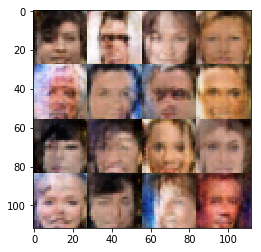

Epoch 1/1... Generator Loss: 0.7793 Discriminator Loss: 0.9998...
Epoch 1/1... Generator Loss: 0.7357 Discriminator Loss: 1.0264...
Epoch 1/1... Generator Loss: 0.5035 Discriminator Loss: 1.4041...
Epoch 1/1... Generator Loss: 0.4994 Discriminator Loss: 1.2960...
Epoch 1/1... Generator Loss: 0.5440 Discriminator Loss: 1.4334...
Epoch 1/1... Generator Loss: 1.1934 Discriminator Loss: 1.1368...
Epoch 1/1... Generator Loss: 0.6646 Discriminator Loss: 1.7704...
Epoch 1/1... Generator Loss: 0.8813 Discriminator Loss: 0.9645...
Epoch 1/1... Generator Loss: 0.4711 Discriminator Loss: 1.3968...
Epoch 1/1... Generator Loss: 0.9838 Discriminator Loss: 1.1526...


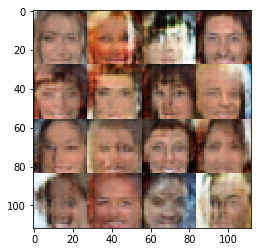

Epoch 1/1... Generator Loss: 0.5081 Discriminator Loss: 1.3064...
Epoch 1/1... Generator Loss: 0.7429 Discriminator Loss: 1.1919...
Epoch 1/1... Generator Loss: 0.4591 Discriminator Loss: 1.3624...
Epoch 1/1... Generator Loss: 0.4913 Discriminator Loss: 1.3629...
Epoch 1/1... Generator Loss: 0.7354 Discriminator Loss: 1.1755...
Epoch 1/1... Generator Loss: 0.8715 Discriminator Loss: 1.0061...
Epoch 1/1... Generator Loss: 0.2767 Discriminator Loss: 2.0106...
Epoch 1/1... Generator Loss: 0.7292 Discriminator Loss: 1.0941...
Epoch 1/1... Generator Loss: 0.7248 Discriminator Loss: 1.5990...
Epoch 1/1... Generator Loss: 0.7206 Discriminator Loss: 1.5644...


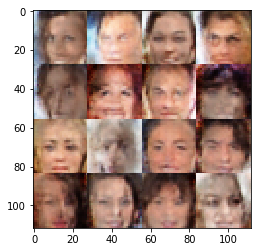

Epoch 1/1... Generator Loss: 0.9411 Discriminator Loss: 1.2038...
Epoch 1/1... Generator Loss: 0.5631 Discriminator Loss: 1.2798...
Epoch 1/1... Generator Loss: 0.3901 Discriminator Loss: 1.5168...
Epoch 1/1... Generator Loss: 0.5065 Discriminator Loss: 1.2322...
Epoch 1/1... Generator Loss: 0.6295 Discriminator Loss: 1.4890...
Epoch 1/1... Generator Loss: 0.9118 Discriminator Loss: 1.3892...
Epoch 1/1... Generator Loss: 0.6862 Discriminator Loss: 1.2370...
Epoch 1/1... Generator Loss: 0.6298 Discriminator Loss: 1.3483...
Epoch 1/1... Generator Loss: 0.6873 Discriminator Loss: 1.2248...
Epoch 1/1... Generator Loss: 0.6645 Discriminator Loss: 1.1899...


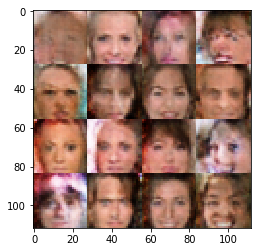

Epoch 1/1... Generator Loss: 0.8273 Discriminator Loss: 1.4130...
Epoch 1/1... Generator Loss: 0.7310 Discriminator Loss: 1.6897...


KeyboardInterrupt: 

In [75]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.